In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import zipfile
!pip install gdown
import gdown

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!gdown --id 1UxZmHg62nAEdmYQONOvFtZIMnzE2Haw_

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1UxZmHg62nAEdmYQONOvFtZIMnzE2Haw_
From (redirected): https://drive.google.com/uc?id=1UxZmHg62nAEdmYQONOvFtZIMnzE2Haw_&confirm=t&uuid=da59ec6b-0224-4950-815a-ca8af1d476cc
To: /kaggle/working/data.zip
100%|█████████████████████████████████████████| 771M/771M [00:04<00:00, 184MB/s]


In [3]:
zip_path = '/kaggle/working/data.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

In [4]:
dir = '/kaggle/working/dataset'
directory = os.listdir(dir)
print(directory)

['cataract', 'glaucoma', 'diabetic_retinopathy', 'normal']


In [5]:
image_paths = []
labels = []

directory = os.listdir(dir)
for i in directory:
    folder_path = os.path.join(dir, i)
    files = os.listdir(folder_path)
    for img in files:
        img_path = os.path.join(folder_path, img)
        image_paths.append(img_path)
        labels.append(i)

In [6]:
len(image_paths)

4217

In [7]:
unique_labels = []
for label in labels:
    if label not in unique_labels:
        unique_labels.append(label)
print(unique_labels)

['cataract', 'glaucoma', 'diabetic_retinopathy', 'normal']


In [8]:
# Concat data paths with label
df = pd.concat([pd.Series(image_paths, name = 'image_paths'), pd.Series(labels, name = 'labels')], axis = 1)
df

,image_paths,labels
0,/kaggle/working/dataset/cataract/_277_8311217.jpg,cataract
1,/kaggle/working/dataset/cataract/cataract_040.png,cataract
2,/kaggle/working/dataset/cataract/_155_2004552.jpg,cataract
3,/kaggle/working/dataset/cataract/_64_2615880.jpg,cataract
4,/kaggle/working/dataset/cataract/_252_5300307.jpg,cataract
...,...,...
4212,/kaggle/working/dataset/normal/2465_right.jpg,normal
4213,/kaggle/working/dataset/normal/2653_left.jpg,normal
4214,/kaggle/working/dataset/normal/2397_right.jpg,normal
4215,/kaggle/working/dataset/normal/3430_left.jpg,normal


In [9]:
# Split data to train, valid, test
from sklearn.model_selection import train_test_split
#train
train , temp = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 7, stratify = df['labels'])

# valid and test
valid, test = train_test_split(temp, train_size = 0.5, shuffle = True, random_state = 7, stratify = temp['labels'])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [10]:
print(len(train))
print(len(valid))
print(len(test))

3373
422
422


In [11]:
# Define model parameter
img_size = (224, 224)
channels = 3
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)

# test data batch size
test_batch_size = max(sorted([len(test) // n for n in range(1, len(test)+1) if len(test)%n == 0 and len(test)/n <= 80]))
test_steps = len(test) // test_batch_size

In [12]:
from keras.preprocessing.image import ImageDataGenerator
def scalar(img):
    return img
training_datagen = ImageDataGenerator(preprocessing_function = scalar, 
                                      horizontal_flip=True,
                                      rotation_range=30,
                                      zoom_range=0.2,      
                                      width_shift_range=0.1,  
                                      height_shift_range=0.1,
                                      brightness_range=[0.8, 1.2])
train_generator = training_datagen.flow_from_dataframe(dataframe=train,
                                          x_col ='image_paths',
                                          y_col = 'labels',
                                          target_size=img_size,
                                          class_mode = 'categorical',
                                          color_mode = color,
                                          shuffle = True,
                                          batch_size = 40)
val_generator = training_datagen.flow_from_dataframe(dataframe=valid,
                                          x_col ='image_paths',
                                          y_col = 'labels',
                                          target_size=img_size,
                                          class_mode = 'categorical',
                                          color_mode = color,
                                          shuffle = True,
                                          batch_size = 40)

testing_datagen = ImageDataGenerator(preprocessing_function = scalar)
testing_generator = testing_datagen.flow_from_dataframe(dataframe=test,
                                          x_col ='image_paths',
                                          y_col = 'labels',
                                          target_size=img_size,
                                          class_mode = 'categorical',
                                          color_mode = color,
                                          shuffle = False,
                                          batch_size = test_batch_size)

Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


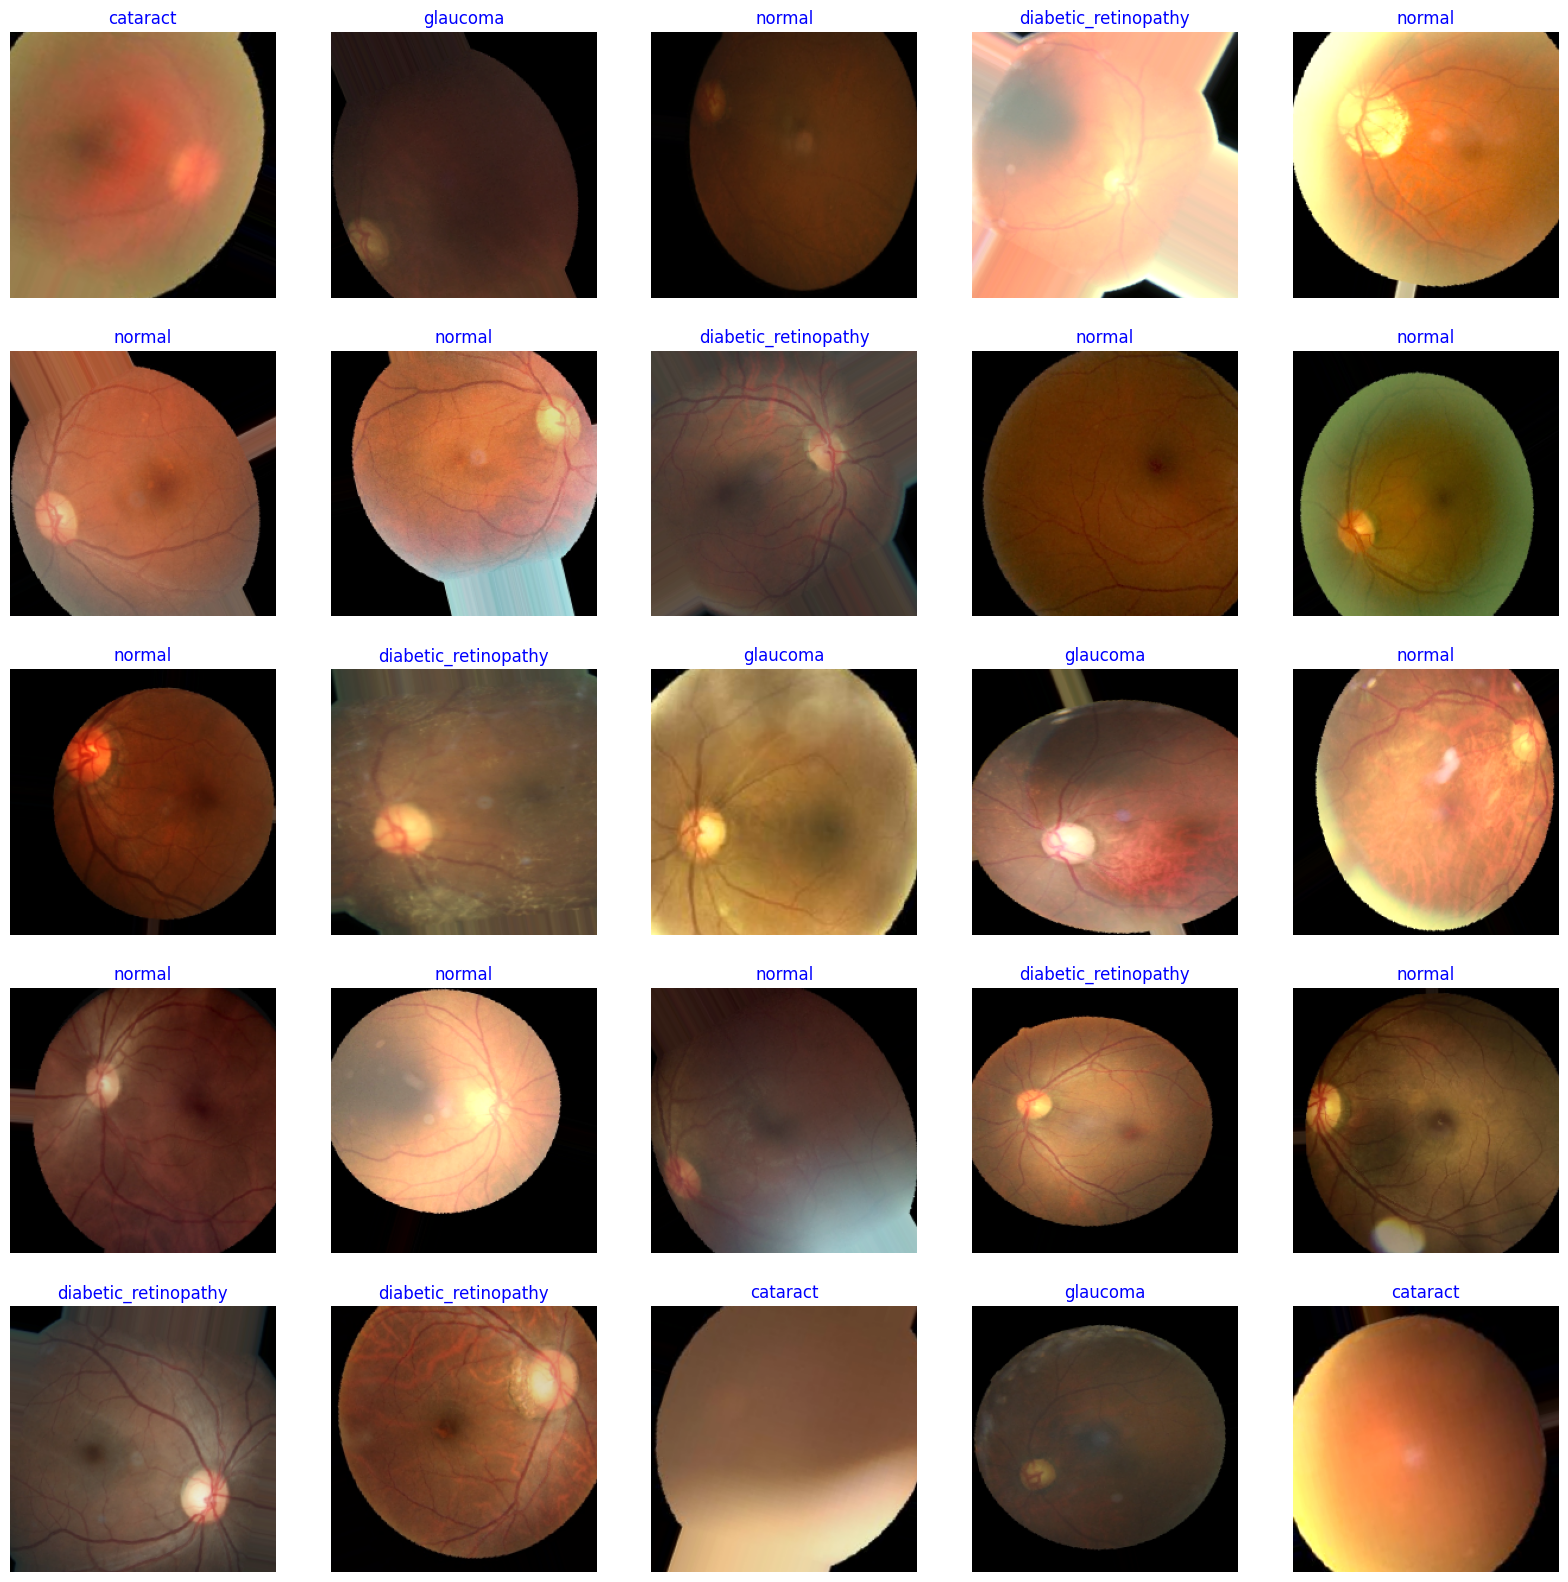

In [13]:
# Show images
import matplotlib.pyplot as plt

def show_sample_images(data_generator, num_samples=25):
    '''
    This function takes a data generator and shows a sample of the images.

    Parameters:
    - data_generator: The data generator providing the images and labels.
    - num_samples: Number of images to display. Default is 25.
    '''

    # Retrieve class information
    class_indices = data_generator.class_indices
    class_names = list(class_indices.keys())

    # Get a batch of samples from the generator
    images, labels = next(data_generator)

    # Calculate the number of displayed samples
    batch_size = len(labels)
    num_displayed_samples = min(batch_size, num_samples)

    plt.figure(figsize=(20, 20))

    for i in range(num_displayed_samples):
        plt.subplot(5, 5, i + 1)
        
        # Scale data to the range (0 - 1)
        image = images[i] / 255
        plt.imshow(image)

        # Get the image index
        index = np.argmax(labels[i])

        # Get the class name of the image
        class_name = class_names[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')

    plt.show()

# Example usage:
# Assuming you have a data generator named 'train_data_gen'
# Adjust the variable name and parameters accordingly
show_sample_images(train_generator, num_samples=25)


In [14]:
# Callbacks
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np

class MyCustomCallback(Callback):
    def __init__(self, patience=1, factor=0.5, stop_patience=3):
        super(MyCustomCallback, self).__init__()
        self.patience = patience
        self.factor = factor
        self.stop_patience = stop_patience
        self.count = 0
        self.stop_count = 0
        self.best_weights = None
        self.best_metric = None

    def lr_schedule(self, epoch):
        initial_lr = 0.01
        drop = 0.5
        epochs_drop = 10
        return initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))

    def on_epoch_end(self, epoch, logs=None):
        lr = self.lr_schedule(epoch)
        current_metric = logs.get('val_loss')
        current_acc = logs.get('accuracy')  # Change 'acc' to 'accuracy'
        current_val_acc = logs.get('val_accuracy')  # Change 'val_acc' to 'val_accuracy'
        
        if self.best_weights is None or current_metric < self.best_metric:
            self.best_weights = self.model.get_weights()
            self.best_metric = current_metric
            self.count = 0
            self.stop_count = 0
        else:
            self.count += 1
            if self.count >= self.patience and current_acc is not None and current_val_acc is not None and current_acc > 0.90 and current_val_acc > 0.90:
                lr *= self.factor
                tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                self.count = 0
                self.stop_count += 1

        if self.stop_count > self.stop_patience:
            self.model.stop_training = True
            print(f"Training stopped after {self.stop_patience} adjustments with no improvement.")
        
        print(f"Epoch {epoch + 1}: val_loss={current_metric:.5f}, acc={current_acc:.5f}, val_acc={current_val_acc:.5f}, lr={lr:.5f}")

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)

In [15]:
from keras.applications import EfficientNetB3

# Created pre-trained model use efficientnetb3 from EfficientNet family
pre_trained_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=img_shape, pooling= 'max')
pre_trained_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0

In [16]:
# Build Model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
model = tf.keras.models.Sequential([
    pre_trained_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(64, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.5, seed= 123),
    Dense(4, activation= 'softmax')])

model.compile(Adamax(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                98368     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 10888307 (41.54 MB)
Trainable params: 1079

In [17]:
callbacks = MyCustomCallback()

In [18]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[callbacks])

Epoch 1/100


2023-12-20 15:08:02.220787: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


85/85 [==============================] - 129s 824ms/step - loss: 3.0527 - accuracy: 0.6680 - val_loss: 3.2008 - val_accuracy: 0.6682
Epoch 2/100
85/85 [==============================] - 67s 786ms/step - loss: 2.3583 - accuracy: 0.8111 - val_loss: 2.4644 - val_accuracy: 0.7938
Epoch 3/100
85/85 [==============================] - 67s 781ms/step - loss: 2.0339 - accuracy: 0.8515 - val_loss: 1.9188 - val_accuracy: 0.8720
Epoch 4/100
85/85 [==============================] - 67s 780ms/step - loss: 1.7824 - accuracy: 0.8835 - val_loss: 1.5791 - val_accuracy: 0.9194
Epoch 5/100
85/85 [==============================] - 67s 780ms/step - loss: 1.5890 - accuracy: 0.9016 - val_loss: 1.4708 - val_accuracy: 0.8981
Epoch 6/100
85/85 [==============================] - 67s 783ms/step - loss: 1.4118 - accuracy: 0.9111 - val_loss: 1.3218 - val_accuracy: 0.9123
Epoch 7/100
85/85 [==============================] - 67s 777ms/step - loss: 1.2651 - accuracy: 0.9140 - val_loss: 1.1582 - val_accuracy: 0.9123
Epo

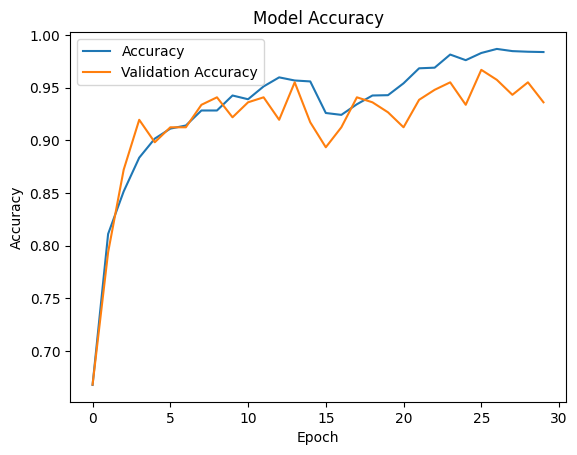

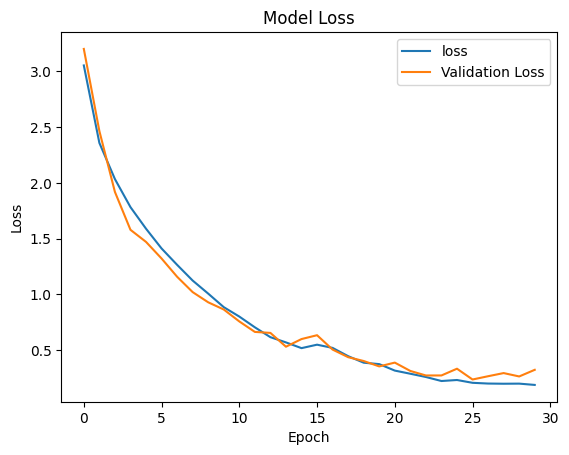

In [25]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [26]:
from keras.models import load_model

model.evaluate(testing_generator)

211/211 [==============================] - 4s 20ms/step - loss: 0.4613 - accuracy: 0.9005


[0.4612741768360138, 0.900473952293396]

In [27]:
predictions = model.predict_generator(testing_generator)

/tmp/ipykernel_5257/435935186.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(testing_generator)


In [22]:
predicted_classes = np.argmax(predictions, axis=1)

# Menampilkan hasil kelas prediksi
print(predicted_classes)

[0 1 2 2 2 3 0 0 3 1 3 0 3 3 1 0 2 1 0 3 1 2 0 3 1 2 0 2 1 0 0 1 2 3 3 2 3
 0 1 2 0 2 2 3 2 1 0 3 0 2 3 0 0 1 1 3 1 1 1 3 1 3 0 0 2 1 1 0 2 0 1 0 0 2
 2 0 1 0 1 2 3 0 1 2 0 1 1 2 2 0 0 3 3 2 2 3 3 3 3 1 2 3 3 0 1 2 1 0 0 0 3
 2 3 0 1 0 1 2 2 0 0 1 3 1 3 0 3 0 3 1 1 0 1 0 3 1 2 3 1 0 3 0 1 0 1 3 1 0
 2 2 0 3 0 1 1 0 1 0 3 0 3 3 2 0 1 2 0 3 1 3 3 3 3 3 1 0 0 3 3 2 3 2 0 1 0
 0 1 3 0 3 0 3 1 2 2 0 1 2 0 2 0 0 3 1 1 3 2 3 0 2 2 2 3 1 2 3 0 1 2 3 0 0
 3 3 1 2 3 2 3 1 1 1 0 3 2 0 3 1 0 0 2 2 1 1 1 0 1 3 3 3 3 3 0 3 0 3 3 0 1
 3 0 0 1 2 3 1 3 2 0 0 3 0 0 2 3 3 3 3 2 2 3 0 0 0 2 0 1 2 3 3 2 3 1 3 1 0
 3 3 3 2 0 0 0 1 2 3 2 0 2 3 0 1 3 3 1 0 1 3 2 2 2 3 3 1 3 1 2 1 3 1 1 0 1
 1 3 2 3 3 1 0 1 0 0 0 3 1 3 2 2 1 2 2 0 1 1 0 1 2 1 3 3 0 2 0 3 1 3 3 3 1
 0 3 1 3 0 2 3 1 1 1 0 3 1 3 0 1 0 3 3 3 2 1 1 3 2 0 1 0 1 0 0 3 1 3 1 2 2
 3 3 3 3 2 3 3 2 3 0 0 0 2 0 3]


In [23]:
model.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
from IPython.display import FileLink
FileLink(r'model.h5')

/kaggle/working/model.h5

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [35]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[102   0   2   0]
 [  1 100   1   8]
 [  5   1  77  17]
 [  5   0   2 101]]
                      precision    recall  f1-score   support

            cataract       0.90      0.98      0.94       104
diabetic_retinopathy       0.99      0.91      0.95       110
            glaucoma       0.94      0.77      0.85       100
              normal       0.80      0.94      0.86       108

            accuracy                           0.90       422
           macro avg       0.91      0.90      0.90       422
        weighted avg       0.91      0.90      0.90       422



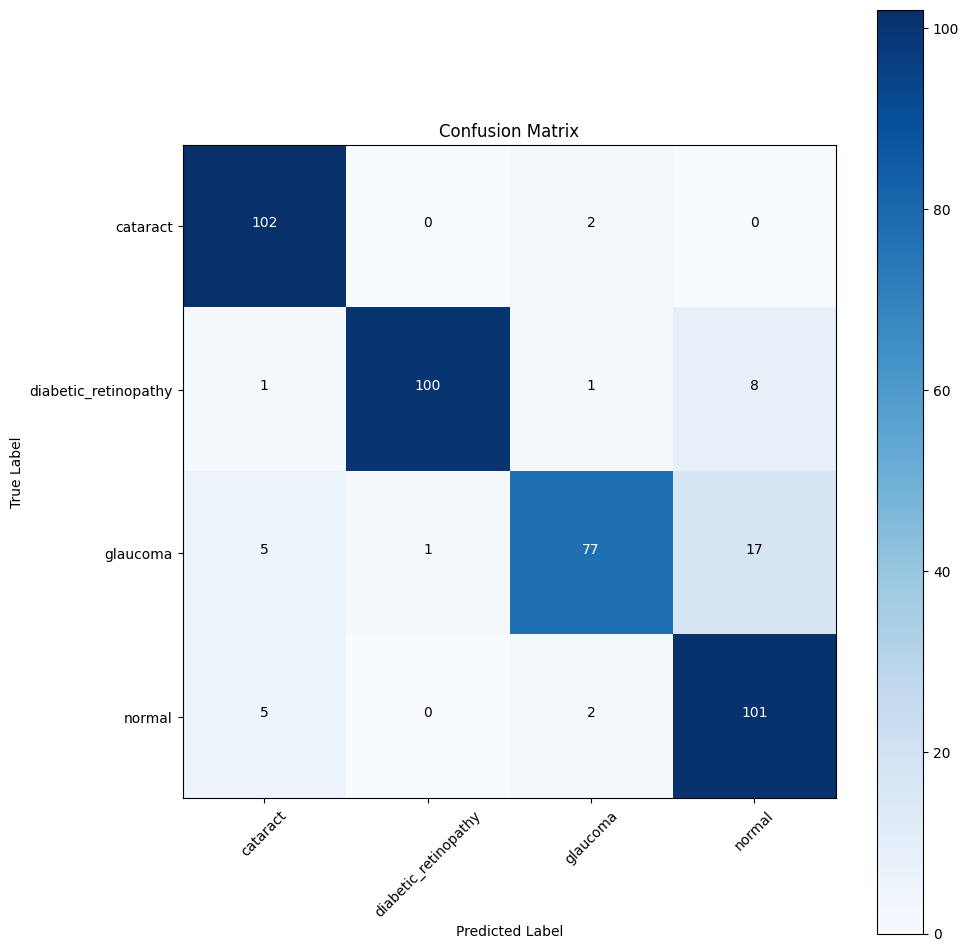

In [38]:
g_dict = testing_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(testing_generator.classes, predicted_classes)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(testing_generator.classes, predicted_classes, target_names= classes))